In [217]:
import os
import sys
import cv2
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch 
from pykeops.torch import LazyTensor
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
import pickle

In [218]:
split = "split_20231212"
experiment = "FWF001"
cell_type = "Proximal"
N = 512

In [219]:
def sample_grid(n, dim=2,dtype=torch.float32,device="cpu"):
    grid_points = torch.linspace(0,1,n,dtype=dtype,device=device)
    grid_points = torch.stack(
        torch.meshgrid((grid_points,) * dim, indexing="ij"), dim=-1
    )
    grid_points = grid_points.reshape(-1, dim)
    return grid_points

y_grid = sample_grid(N)
R = 0.1

# y_i = LazyTensor(y_grid[:,None,:])
# y_j = LazyTensor(y_grid[None,:,:])
# Y_ij = (R**2 - (y_i - y_j)**2).step()

def neighbours_grid(i,y_grid,R):
    yi = y_grid[i,:].reshape((1,2))
    return (((yi - y_grid)**2).sum(1) <= R**2).float().squeeze()



In [220]:
y_grid.shape

torch.Size([262144, 2])

In [221]:
data_dir = split+"_"+experiment+"_smooth/"+cell_type+"/data/"
T = len([name for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))])

In [222]:
data = torch.zeros((512,512,T))
for t in range(1,T+1):
    with open(data_dir + "data_" + str(t) + ".pkl", 'rb') as file:
        data[:,:,t-1] = pickle.load(file)

In [223]:
# plt.plot(smooth_max)
# # plt.plot(data.reshape((N*N,T))[data_max[1][-1].item(),:])

In [224]:
%matplotlib widget
from matplotlib.widgets import Button, Slider

def smooth_max(data,y_grid,R):
    N = data.shape[0]
    T = data.shape[2]
    data_max = torch.max(data.reshape((N*N,T)),dim=0)
    ngh_max = neighbours_grid(data_max[1][-1].item(),y_grid,R).bool()
    smooth_max = data.reshape((N*N,T))[ngh_max,:].sum(0) * (1/N)**2
    return data_max[1][-1].item(), smooth_max
    
def data_to_smax(data,y_grid,R=0.1):
    index, smax = smooth_max(data,y_grid,R)
    yx = y_grid[index,0].item()
    yy = y_grid[index,1].item()
    fig, axs = plt.subplots(1,2,figsize=(8,4))
    cmap_base = pl.cm.Blues
    # Get the colormap colors
    cmap = cmap_base(np.arange(cmap_base.N))
    # Set alpha
    cmap[:,-1] = np.linspace(0, 1, cmap_base.N)
    # Create new colormap
    cmap = ListedColormap(cmap)

    im = axs[0].imshow(data[:,:,0].numpy().transpose(),origin='lower',cmap=cmap,vmin=0.0,vmax=data[:,:,-1].max().item())
    axs[0].invert_yaxis()
    axs[0].set_aspect("equal")
    
    scat = axs[0].scatter([yx*N],[yy*N],s=15,c='red')
    circ = axs[0].plot(N*(yx + R*np.cos(2*math.pi*np.linspace(0,1,100))),N*(yy + R*np.sin(2*math.pi*np.linspace(0,1,100))),c='r')

    maxplot, = axs[1].plot(smax)
    timeline = axs[1].vlines(x=0,ymin=0,ymax=1.1*smax.max().item(),color='r')
    # axs[1].set_xlim(0,T)
    # axs[1].set_ylim(0,1.05*smax.max())
    fig.subplots_adjust(left=0.25, bottom=0.25)
    
    
    axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    frame_slider = Slider(
        ax=axtime,
        label='FRAME',
        valmin=1,
        valmax=T,
        valinit=1,
        valstep=1
    )
    
    def update(val):
        im.set_data(data[:,:,frame_slider.val-1].numpy().transpose())
        # maxplot.set_ydata(smax[:frame_slider.val-1])
        timeline.set_segments([np.array([[frame_slider.val-1, 0], [frame_slider.val-1, 1.1*smax.max().item()]])])
        fig.canvas.draw_idle()
    
    frame_slider.on_changed(update)
    
    
    return fig, axs



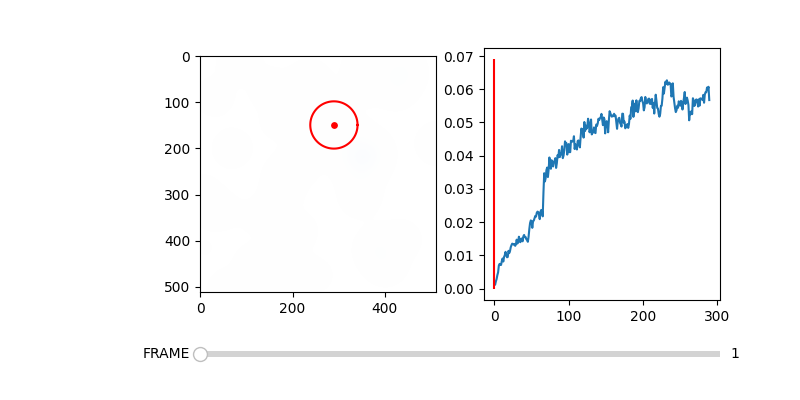

In [225]:
fig, axs = data_to_smax(data,y_grid,R=0.1)